In [1]:
# NOTE: !!! THIS CELL SHOULD BE RUN FIRST !!!

# Jupyter notebooks have a bad interaction with virtual environments: 
# they perceive the PYTHONPATH as the folder the venv was activated
# instead of whatever the current directory of the .ipynb file is
# so we need to incorporate this hack

import sys

filepath = "/Users/colinyao/Desktop/Code/FINM/Portfolio_36700"
# change this path to whatever the path to this file is on your computer
sys.path.append(filepath)

import os
os.chdir(filepath)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression as LR
import scipy as sp

In [36]:
data_path = "./data/gmo_analysis_data.xlsx"
rfr = pd.read_excel(data_path, sheet_name='risk-free rate', index_col=0)['TBill 3M']
rfr = rfr / 12  # supposedly the rfr is annualized?

gmwax = pd.read_excel(data_path, sheet_name='total returns', index_col=0)['GMWAX']
gmwax_er = gmwax - rfr

## 2.1

In [37]:
def report_univariate_performance_stats(ser: pd.Series):
    # reports mean, volatility, sharpe
    num_to_annualize = 12  # modify based on samples - weekly monthly yearly
    mean = ser.mean() * num_to_annualize
    vol = ser.std() * (num_to_annualize ** 0.5)
    sharpe = mean / vol

    return pd.Series([mean, vol, sharpe], index=['Mean', 'Vol', 'Sharpe'], name=ser.name)

gmwer_front = gmwax_er[gmwax_er.index < '2012-01-01']
gmwer_back = gmwax_er[gmwax_er.index >= '2012-01-01']

table21 = pd.concat([report_univariate_performance_stats(s) for s in [gmwer_front, gmwer_back, gmwax_er]], axis=1)
table21.columns = ['inception-2011', '2012-present', 'inception-present']
display(table21)

,inception-2011,2012-present,inception-present
Mean,0.046422,0.049157,0.047730
Vol,0.110499,0.092661,0.102209
Sharpe,0.420110,0.530503,0.466986


It appears that mean returns are roughly constant over this time period. A slight increase in mean returns and a slight decrease in vol means that the Sharpe ratio increased by a decent amount. 

## 2.2

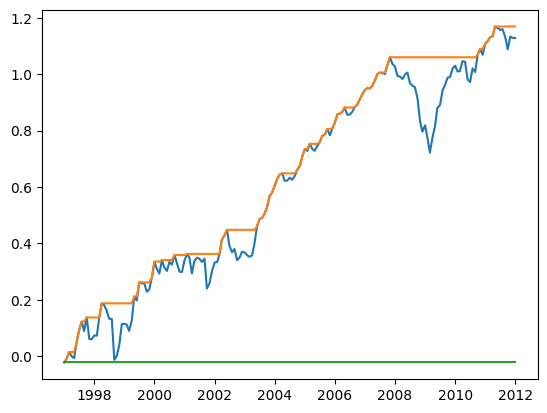

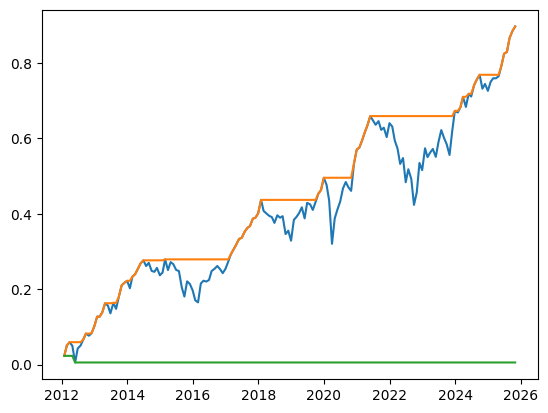

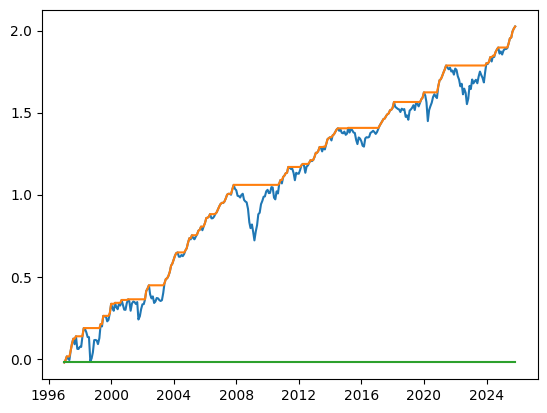

,inception-2011,2012-present,inception-present
min return,-0.149150,-0.115018,-0.149150
VaR-0.05,-0.044003,-0.039814,-0.041147
max drawdown,-1.190928,-0.891160,-2.046596


In [ ]:
def tail_risks(ser):
    # assumes that ser adjusted for rfr and attempts to add it back
    add_back_rfr = rfr[ser.index]
    min_return = ser.min()
    var_five = ser.quantile(0.05)
    orig_ser = ser + add_back_rfr
    cumu_performance = orig_ser.cumsum()

    plt.plot(cumu_performance)
    plt.plot(cumu_performance.cummax())
    plt.plot(cumu_performance.cummin())
    plt.show()

    max_drawdown = -max(cumu_performance.cummax() - cumu_performance.cummin())

    # max_drawdown = cumu_performance.min()

    return pd.Series([min_return, var_five, max_drawdown], index=['min return', 'VaR-0.05', 'max drawdown'])

table22 = pd.concat([tail_risks(s) for s in [gmwer_front, gmwer_back, gmwax_er]], axis=1)
table22.columns = ['inception-2011', '2012-present', 'inception-present']
display(table22)

# TODO: fix later

(a): GMWAX does not seem to have high tail risk. The minimum return is about thrice the magnitude of the 0.05-level VaR. 

(b): This relation is more pronounced in the earlier period, as the minimum return over the entire time period occurs there. Nevertheless the 0.05-VaR appears to be roughly consistent. 

## 2.3

In [39]:
spy = pd.read_excel(data_path, sheet_name='total returns', index_col=0)['SPY']
spy_er = spy - rfr

def spy_compare(gm_ser):
    spy_slice = spy_er[gm_ser.index]

    gm_spy_lr = LR()
    gm_spy_lr.fit(pd.DataFrame(spy_slice), gm_ser)

    return pd.Series([gm_spy_lr.intercept_, gm_spy_lr.coef_[0], gm_spy_lr.score(pd.DataFrame(spy_slice), gm_ser)], index=['alpha', 'beta', 'R2'])

table23 = pd.concat([spy_compare(s) for s in [gmwer_front, gmwer_back, gmwax_er]], axis=1)
table23.columns = ['inception-2011', '2012-present', 'inception-present']
display(table23)

,inception-2011,2012-present,inception-present
alpha,0.002250,-0.002280,0.000179
beta,0.542128,0.566914,0.547452
R2,0.648686,0.730904,0.675236


- I don't think you can call GMWAX a low-beta strategy. Having a beta of around 0.5-0.6 indicates fairly high correlation with SPY, and this has remained relatively constant over both the time periods. 
- GMWAX does not appear to provide alpha. The magnitude of the value of alpha is relatively small. The small amount of alpha it provided before the case is offset in the overall sample by the negative alpha provided after the case. 

## 2.4

In [40]:
gmgex = pd.read_excel(data_path, sheet_name='total returns', index_col=0)['GMGEX']
gmgex_er = gmgex - rfr
gmgex_samples = [gmgex_er[gmgex.index < '2012-01-01'], gmgex_er[gmgex.index >= '2012-01-01'], gmgex_er]

table241 = pd.concat([report_univariate_performance_stats(s) for s in gmgex_samples], axis=1)
table241.columns = ['inception-2011', '2012-present', 'inception-present']
display(table241)

table242 = pd.concat([tail_risks(s) for s in gmgex_samples], axis=1)
table242.columns = ['inception-2011', '2012-present', 'inception-present']
display(table242)

table243 = pd.concat([spy_compare(s) for s in gmgex_samples], axis=1)
table243.columns = ['inception-2011', '2012-present', 'inception-present']
display(table243)

,inception-2011,2012-present,inception-present
Mean,-0.003823,0.013182,0.004312
Vol,0.147253,0.228077,0.189982
Sharpe,-0.025963,0.057794,0.022695


,inception-2011,2012-present,inception-present
min return,-0.151592,-0.658863,-0.658863
VaR-0.05,-0.082292,-0.065603,-0.075737
max drawdown,-0.090184,-0.590203,-0.220444


,inception-2011,2012-present,inception-present
alpha,-0.002600,-0.008139,-0.005064
beta,0.764237,0.821257,0.781633
R2,0.725898,0.253171,0.398403


### 2.4.1
Volatility appears to have increased significantly for GMGEX in the period since the case. Mean returns have gone from negative to positive as well, which has caused Sharpe to increase. 

### 2.4.2
Tail risk appears to be much higher in GMGEX in the period since the case. A minimum return ten times than the 0.05-level VaR is much higher than we would expect. The tail risk level in the period before the case appears in line with that of GMWAX. 

### 2.4.3
- GMGEX also does not seem to be a low-beta strategy as the beta value is around 0.8. 
- GMGEX does not appear to have provided much alpha in either time period. 

## 2.4
GMGEX differs from GMWAX in that the tail risk appears to be much higher in the time period since the case, and the correlation with SPY appears to be stronger. 

## 3.1

In [91]:
dp = pd.read_excel(data_path, sheet_name=1, index_col=0)['SPX D/P']
ep = pd.read_excel(data_path, sheet_name=1, index_col=0)['SPX E/P']
tyr = pd.read_excel(data_path, sheet_name=1, index_col=0)['T-Note 10YR']


dp_one = dp.shift(1).dropna()
ep_one = ep.shift(1).dropna()
all_one = pd.read_excel(data_path, sheet_name=1, index_col=0).shift(1).dropna()
# tyr_one = tyr.shift(1).dropna()

spy_zero = spy_er.loc[dp_one.index]

def abr_lr(iv, dv):
    lr = LR()
    lr.fit(iv, dv)
    return pd.Series([lr.intercept_] + list(lr.coef_) +  [lr.score(iv, dv)], index=['alpha'] + ['beta'] * len(lr.coef_) + ['r2'])

for k, v in {'dp': dp_one, 'ep': ep_one, 'all': all_one}.items():
    print(k)
    print(abr_lr(pd.DataFrame(v), spy_zero))

# table31 = pd.concat([abr_lr(pd.DataFrame(var), spy_zero) for var in [dp_one, ep_one, all_one]], axis=1)
# table31.columns = ['DP', 'EP', 'All 3']
# display(table31)

dp
alpha   -0.014011
beta     1.171755
r2       0.011561
dtype: float64
ep
alpha   -0.007194
beta     0.264020
r2       0.005819
dtype: float64
all
alpha   -0.003545
beta     0.568923
beta     0.136755
beta    -0.197803
r2       0.014541
dtype: float64


## 3.2

In [ ]:
def trade_forecast(iv, dv):
    lr = LR()
    lr.fit(iv, dv)

    forecasted_return = pd.Series(lr.predict(iv), index=iv.index)
    # forecasted_return = pd.Series(lr.predict(iv), index=iv.index).shift(1).dropna()
    # print(forecasted_return)
    scale = 100 * forecasted_return
    aligned_dv = dv.loc[scale.index]
    strategy_return = scale * aligned_dv

    market_lr = LR()
    market_lr.fit(pd.DataFrame(aligned_dv), strategy_return)

    # good ol annualization constant
    info_ratio = (12 ** 0.5) * (strategy_return.mean() - aligned_dv.mean()) / (strategy_return - aligned_dv).std()

    return pd.Series([
        strategy_return.mean() * 12,
        strategy_return.std() * (12 ** 0.5),
        strategy_return.mean() * (12 ** 0.5) / strategy_return.std(),
        strategy_return.cumsum().min(),
        market_lr.intercept_ * 12,
        market_lr.coef_[0],
        info_ratio
    ], index=[
        'mean',
        'volatility',
        'Sharpe',
        'max drawdown',
        'alpha',
        'beta',
        'info ratio'
    ])

table32 = pd.concat([trade_forecast(pd.DataFrame(factor), spy_zero) for factor in [dp_one, ep_one, all_one]], axis=1)
table32.columns = ['dp', 'ep', 'all']
display(table32)

,dp,ep,all
mean,0.086599,0.073108,0.093602
volatility,0.158435,0.131976,0.156400
Sharpe,0.546594,0.553950,0.598479
max drawdown,-0.424047,-0.002150,-0.324808
alpha,0.018636,0.008299,0.027164
beta,0.804736,0.767394,0.786678
info ratio,0.020704,-0.163484,0.087419


## 3.3

In [ ]:
def trade_forecast_returns_only(iv, dv):
    lr = LR()
    lr.fit(iv, dv)

    forecasted_return = pd.Series(lr.predict(iv), index=iv.index)
    scale = 100 * forecasted_return
    aligned_dv = dv.loc[scale.index]
    return scale * aligned_dv

